In [848]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json
import scipy.stats as stats
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('ggplot')

%matplotlib inline
plt.rc('figure', figsize=(10,8))
plt.rc('patch', force_edgecolor=True, ec='black', lw=1.2)
# plt.rcdefaults()

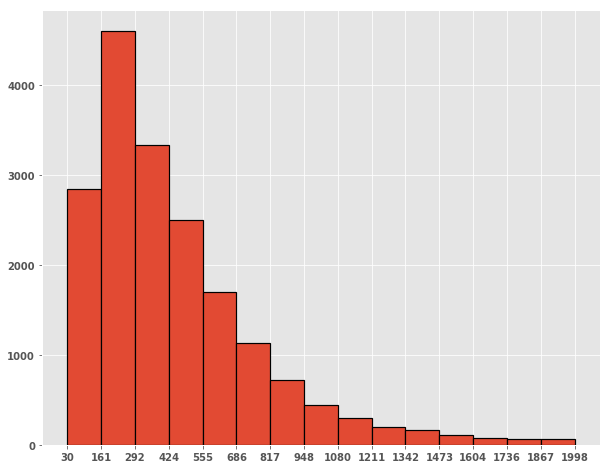

In [261]:

# counts, bins, patches = recipes.hist('calories')
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(recipes['calories'], bins=15)
_ = ax.set_xticks(bins)

What kind of recipes, in terms of nutritions, are represented in the dataset? Overall picture of the data.

Explore trends/pattern, relationships between nutritional data. E.g. Calories relationship to fat, carb, protein, etc....
Official figures: 4 calories/gram of carb, 4 per gram/protein, 9 calories/gram of fat

Looking at the baseline 2000 calories diet, what do the data reveal about the types of recipes scraped from Epicurious in terms of nutritional values? In other words, how do the different nutritions compare in content? Fat, carb, protein in relation to the recommended for a 2000 calories diet. 

What types of recipes, in terms of major ingredients, tend to be more relatively "healthy" based on caloric and macro nutrient values?

Various statistics: Ingredient counts, categories/tags counts, directions and description word counts. Ratings vs. main ingredients. Nutritions vs. main ingredients.

Correlation between various counts. e.g. length of description/direction against ingredient counts.

Compare different notable categories: vegetarian, vegan, meat

In [4]:
recipes = pd.read_pickle('recipes.pkl')
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18277 entries, 0 to 18276
Data columns (total 12 columns):
calories       18277 non-null int64
carb           18277 non-null int64
categories     18277 non-null object
date           18277 non-null datetime64[ns]
desc           13655 non-null object
directions     18277 non-null object
fat            18277 non-null int64
ingredients    18277 non-null object
protein        18277 non-null int64
rating         18277 non-null float64
sodium         18277 non-null int64
title          18277 non-null object
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 1.7+ MB


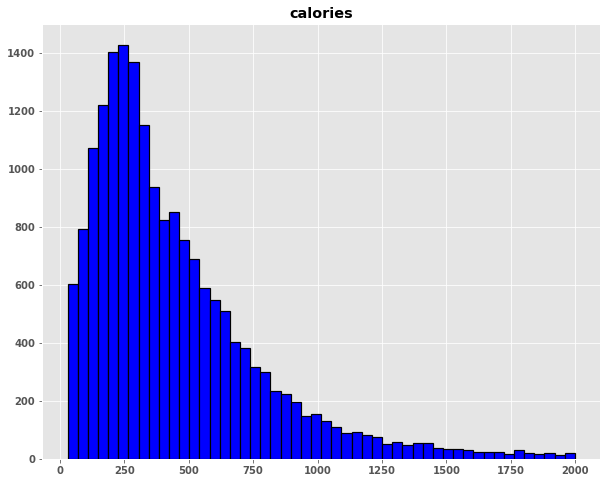

In [583]:
_ = recipes.hist('calories', bins=50, color = 'b')

In [5]:
recipes.head()

,calories,carb,categories,date,desc,directions,fat,ingredients,protein,rating,sodium,title
0,426,77,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",2006-09-01 04:00:00,None,"[1. Place the stock, lentils, celery, carrot, ...",7,"[4 cups low-sodium vegetable or chicken stock,...",30,2.500,559,"Lentil, Apple, and Turkey Wrap"
1,403,34,"[Food Processor, Onion, Pork, Bake, Bastille D...",2004-08-20 04:00:00,This uses the same ingredients found in boudin...,[Combine first 9 ingredients in heavy medium s...,23,"[1 1/2 cups whipping cream, 2 medium onions, c...",18,4.375,1439,Boudin Blanc Terrine with Red Onion Confit
2,357,92,"[Candy, Citrus, Quick & Easy, Low Sodium, Grap...",2004-08-20 12:48:48,None,[Quarter the grapefruits lengthwise and remove...,0,"[3 large grapefruits, 13 cups cold water, 4 cu...",1,5.000,17,Candied Grapefruit Zest
3,691,21,"[Leafy Green, Shellfish, Marinate, Sauté, High...",2004-08-20 04:00:00,When Roy Yamaguchi invited me to cook at the 5...,"[Preheat oven to 350°F., Dip each crab in milk...",41,"[8 soft shell crabs, cleaned (See note), 1 cup...",57,3.750,1533,Soft-Shell Crabs with Wilted Spinach and Warm ...
4,181,39,"[Sauce, Fruit, Ginger, Dessert, Low Sodium, Wh...",2004-08-20 04:00:00,A simple dessert sauce that is absolutely deli...,"[Combine Sauternes, sugar, water and whole clo...",1,[1/2 cup plus 2 tablespoons Sauternes or Late ...,1,5.000,11,Kumquat Compote with Sauternes and Ginger


In [ ]:
# 13,655 out of 18,277 recipes contain description
descriptions = recipes.loc[~recipes.desc.isnull()].reset_index(drop=True)

In [774]:

def counts_dist(text_corp, prep = None, tok = None, bins = 10, plot = False):
    
    if prep:
        vect = CountVectorizer(preprocessor=prep, tokenizer=tok)
    else:
        vect = CountVectorizer()
        
    count_mat = vect.fit_transform(text_corp)
    wc = np.array(count_mat.sum(axis=1)).flatten()
    
    if plot:
        plt.hist(wc, bins = bins)

    return pd.Series(wc).describe(), wc

(count    13655.000000
 mean        30.832589
 std         25.653103
 min          1.000000
 25%         13.000000
 50%         24.000000
 75%         40.000000
 max        307.000000
 dtype: float64, array([19, 89, 17, ..., 27, 44, 81], dtype=int64))

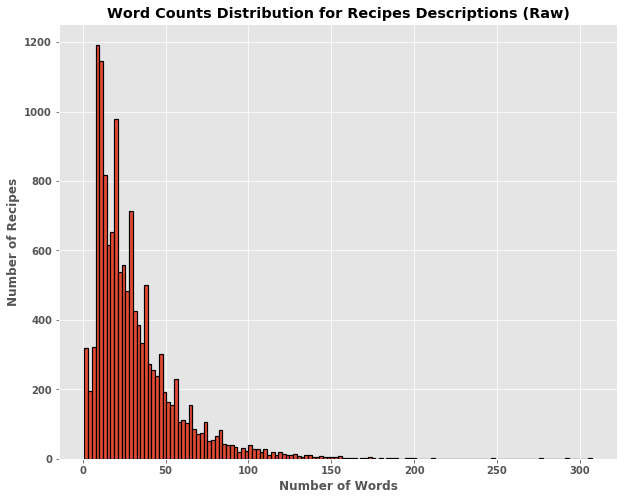

In [784]:
# Distribution of word counts in descriptions for recipes with a description. Before cleaning.
desc_stats = counts_dist(descriptions.desc, bins='auto', plot = True)
_ = plt.title('Word Counts Distribution for Recipes Descriptions (Raw)')
_ = plt.xlabel('Number of Words')
_ = plt.ylabel('Number of Recipes')
desc_stats

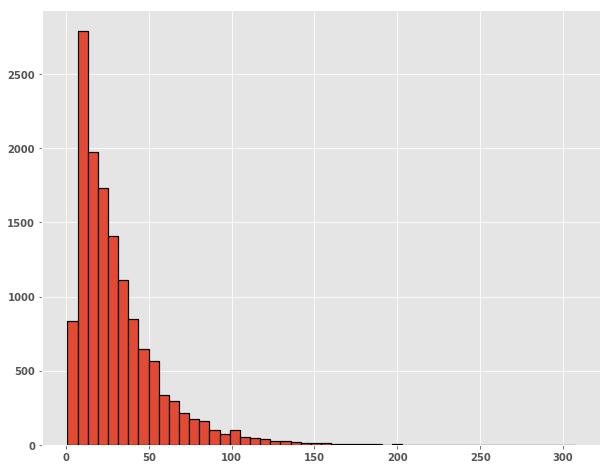

In [786]:
# 50 bins
_ = counts_dist(descriptions.desc, bins=50, plot = True)

(count    18277.00000
 mean       149.72501
 std         98.82470
 min          1.00000
 25%         83.00000
 50%        127.00000
 75%        192.00000
 max       1237.00000
 dtype: float64, array([145, 241, 235, ...,  71, 137, 311], dtype=int64))

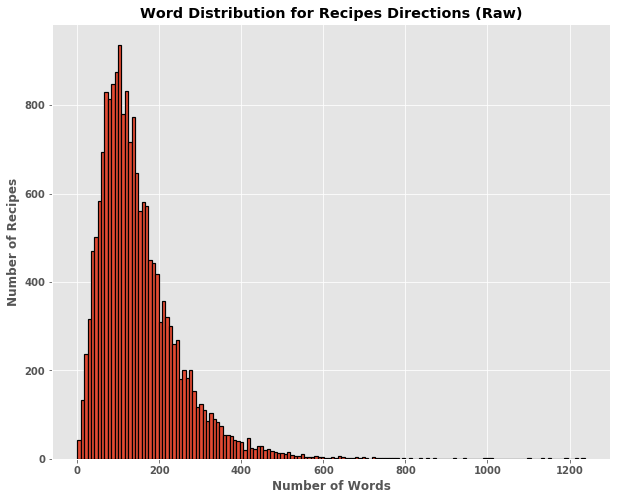

In [782]:
# Distribution of word counts in directions for recipes. Before cleaning.

def list_prep(text_list):
    return ' '.join(e for e in text_list).lower()

dir_stats = counts_dist(recipes.directions, prep=list_prep, bins='auto', plot = True)
_ = plt.title('Word Distribution for Recipes Directions (Raw)')
_ = plt.xlabel('Number of Words')
_ = plt.ylabel('Number of Recipes')
dir_stats

(count    18277.000000
 mean        10.406084
 std          4.508740
 min          1.000000
 25%          7.000000
 50%         10.000000
 75%         13.000000
 max         41.000000
 dtype: float64, array([15, 28,  4, ...,  5,  7, 16], dtype=int64))

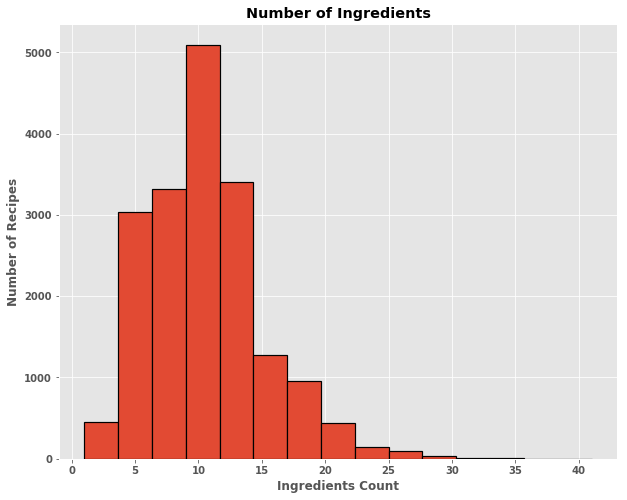

In [790]:
# Distribution of number of ingredients
def dummy(text): # Dummy funct. to use our lists with CountVectorizer
    return text

ingr_stats = counts_dist(recipes.ingredients, prep=dummy, tok=dummy, bins=15, plot=True)
_ = plt.title('Number of Ingredients')
_ = plt.xlabel('Ingredients Count')
_ = plt.ylabel('Number of Recipes')
ingr_stats

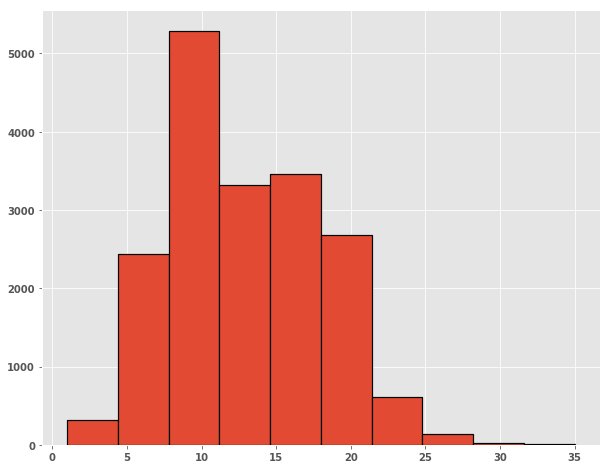

In [791]:
# Distribution of number of categories
cat_stats = counts_dist(recipes.categories, prep=dummy, tok=dummy, bins=10, plot=True)

count     721.000000
mean      325.233010
std       962.797949
min         1.000000
25%         8.000000
50%        47.000000
75%       227.000000
max      9034.000000
dtype: float64

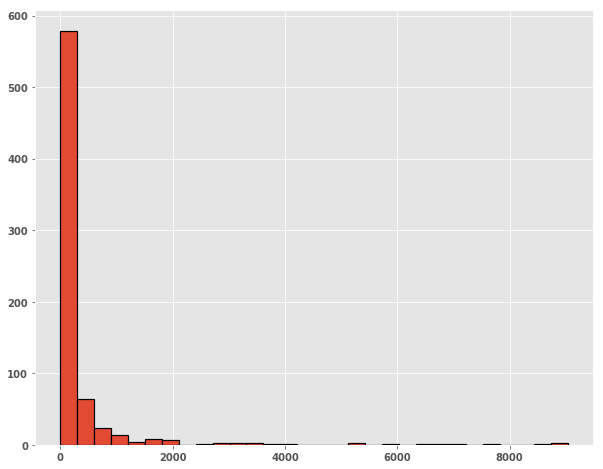

In [832]:
# Counting frequency of categories.

# all_cats = []
# [all_cats.extend(cat) for cat in recipes.categories]
# categories = pd.Series(all_cats)
cat_freq = categories.value_counts()

_ = plt.hist(categories.value_counts(),bins=30)
cat_freq.describe()

In [833]:
cat_freq

Peanut Free                9034
Soy Free                   8741
Bon Appétit                8630
Tree Nut Free              7692
Vegetarian                 7153
Kosher                     6710
Pescatarian                6590
Gourmet                    6008
Wheat/Gluten-Free          5407
Quick & Easy               5321
Bake                       4052
Summer                     3782
Dairy Free                 3532
Side                       3457
No Sugar Added             3356
Dinner                     3179
Dessert                    3109
Sugar Conscious            2834
Fall                       2817
Winter                     2788
Kidney Friendly            2437
Sauté                      2064
Kid-Friendly               2029
Vegan                      1998
Vegetable                  1983
Tomato                     1968
Onion                      1865
Healthy                    1833
Egg                        1721
Milk/Cream                 1694
                           ... 
Louisvil

In [834]:
cat_freq[cat_freq == 1]

Malaysia                   1
Aperitif                   1
Cuba                       1
Bronx                      1
Guacamole                  1
Amagansett                 1
Nebraska                   1
Thailand                   1
Guam                       1
South Dakota               1
Kitchen Olympics           1
Camping                    1
Fritter                    1
Mortar and Pestle          1
Mississippi                1
Cookbook Critic            1
Windsor                    1
Hungary                    1
Burrito                    1
Idaho                      1
Jamaica                    1
Germany                    1
Iowa                       1
West Virginia              1
Bread Machine              1
Louisville                 1
Turkey                     1
Queens                     1
Egypt                      1
Air Fryer                  1
Westwood                   1
New Zealand                1
China                      1
The Chew                   1
Epi Loves the 

In [166]:
recipes.ingredients[0]

['4 cups low-sodium vegetable or chicken stock',
 '1 cup dried brown lentils',
 '1/2 cup dried French green lentils',
 '2 stalks celery, chopped',
 '1 large carrot, peeled and chopped',
 '1 sprig fresh thyme',
 '1 teaspoon kosher salt',
 '1 medium tomato, cored, seeded, and diced',
 '1 small Fuji apple, cored and diced',
 '1 tablespoon freshly squeezed lemon juice',
 '2 teaspoons extra-virgin olive oil',
 'Freshly ground black pepper to taste',
 '3 sheets whole-wheat lavash, cut in half crosswise, or 6 (12-inch) flour tortillas',
 '3/4 pound turkey breast, thinly sliced',
 '1/2 head Bibb lettuce']

In [889]:
#Stop words, adding recipes specific words to sklearn and nltk's builtin lists
from sklearn.feature_extraction import stop_words
from sklearn.metrics.pairwise import cosine_similarity

sw = set(stop_words.ENGLISH_STOP_WORDS)
sw.update(nltk.corpus.stopwords.words('english'))

In [ ]:
# r'\b\w[^\d\W]{2,}\b' 


In [890]:
desc_tfidf = TfidfVectorizer(stop_words=sw, token_pattern=r'\b\w[^\d\W]{2,}\b', )
desc_mat = desc_tfidf.fit_transform(descriptions.desc)
cos_sims = cosine_similarity(desc_mat, desc_mat)

In [872]:


# def preprocess(text):
    
#     sw = nltk.corpus.stopwords.words('english')

#         tok = nltk.wordpunct_tokenize(text)
#         tok = [w for w in tok if w not in nltk.corpus.stopwords.words('english')]
# #     return(' '.join(tok))
#     return tok

# preprocess(sent[0])

In [873]:
# descriptions.ingredients[1]

In [883]:
sent = [["This is a test mr. sentence 4, you've we'll you didn't,10 100 10this is not!, @", 'this is good great', 'nothing good good here'],['this', 'that']]
# sent = ["this is a test mr. sentence 4 you didn't, wouldn't this is not!, @."]
# vect = CountVectorizer(preprocessor=lambda x:x, tokenizer=lambda x:x)
vect = CountVectorizer(token_pattern=r'\b[^\d\W]+\b')
# , token_pattern=r'\b[^\d\W]+\b'
vect_mat = vect.fit_transform(sent[0])
# vect_mat.toarray()
print(vect_mat)
vect_mat.sum(axis=1)

  (0, 8)	1
  (0, 11)	1
  (0, 1)	1
  (0, 6)	1
  (0, 15)	1
  (0, 14)	1
  (0, 16)	2
  (0, 10)	1
  (0, 7)	1
  (0, 12)	1
  (0, 0)	1
  (0, 5)	2
  (0, 13)	1
  (1, 3)	1
  (1, 2)	1
  (1, 5)	1
  (1, 13)	1
  (2, 4)	1
  (2, 9)	1
  (2, 2)	2


matrix([[15],
        [ 4],
        [ 4]], dtype=int64)

In [861]:
sent[0][0]

"This is a test mr. sentence 4 you didn't,10 100 10this is not!, @"

In [881]:
vect.vocabulary_

{'this': 12,
 'is': 5,
 'a': 0,
 'test': 11,
 'mr': 6,
 'sentence': 9,
 'you': 13,
 'didn': 1,
 't': 10,
 'not': 7,
 'good': 2,
 'great': 3,
 'nothing': 8,
 'here': 4}

In [865]:
pattern = re.compile('(?u)\\b\\w\\w+\\b')
pattern
#r'\b[^\d\W]+\b'
pattern.findall(sent[0][0])

['This',
 'is',
 'test',
 'mr',
 'sentence',
 'you',
 'didn',
 '10',
 '100',
 '10this',
 'is',
 'not']

In [888]:
pat2 = re.compile(r'\b\w[^\d\W]{2,}\b')
pat2.findall(sent[0][0])

['This', 'test', 'sentence', 'you', 'you', 'didn', 'not']

In [93]:
descriptions.desc[1]

'When Roy Yamaguchi invited me to cook at the 5th Anniversary celebration of his Oahu restaurant, I wanted to bring him something special from my neck of the woods and decided to attempt to transport soft-shelled crabs. I say "attempt" because soft-shells are very delicate and I wasn\'t sure they\'d survive the long trip to Hawaii. Happily, of the 10 dozen live ones we packed up, about 8 dozen were still kicking when we got to our destination. I served them with simple accompaniments like wilted spinach and a crushed summer tomato vinaigrette.'